# Tweet Sentiment Analysis -- Canadian 2019 Election

In [0]:
#!pip install wordcloud
import nltk
nltk.download('punkt')
import html
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 700)
from bs4 import BeautifulSoup
import re
import string
from tqdm.auto import tqdm
from wordcloud import WordCloud
# tqdm.pandas()
# %load_ext autotime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords 
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from nltk.stem import PorterStemmer
nltk.download('stopwords')
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
Election = pd.read_csv('Canadian_elections_2019.csv')
Tweet = pd.read_csv("generic_tweets.txt")

In [0]:
Election.head(10)

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that. #cdnpoli #elxn43 #Canada #abortion"""
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"""
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"""
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#elxn43 \n\nCan't decide? This should help!\n\nhttps://t.co/UNe5J1tDJ6"""
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk"""
5,negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - #BlastFromThePast - In 2012 #Conservatives introduced the end of the long-gun registry even though all heads of police across Canada and victims' groups objected for crime control and public safety! #GunLobby https://t.co/WgZKMSQ4wa"""
6,positive,NaN,"b""#CDNmedia #elxn43 #cdnpoli #PPC Rocky Dong hands down has the best election video ever. Please google Rocky Dong boxes socialism if you haven't seen it. Go Rocky! https://t.co/1ruti2ruRZ"""
7,positive,NaN,"b""#cdnpoli #elxn43 The Liberals ++ more than double what was promised in 2015, to the national debt. Now for the next term - if re-elected, they're forecasting $90 billion. This is w/out a national pharmacare program incl and w/out an NDP coalition. $180 billion seems possible imo."""
8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don't Make America's Mistakes | Full Frontal on TBS https://t.co/PhU4jHxnMF via @YouTube"""
9,negative,Scandal,"b""#CPCKinsellaGate\nLet's see the receipts. Who pays Warren Kinsella to make up sleaze?\n#cdnpoli\n#elxn43 \n#VoteLiberal \xf0\x9f\x87\xa8\xf0\x9f\x87\xa6\n#ChooseForward https://t.co/34ltshteve"""


In [0]:
Tweet[Tweet['user']=='Kenichan']

,class,id,date,query,user,text
100691,4,1467951799,Mon Apr 06 22:58:03 PDT 2009,NO_QUERY,Kenichan,"@aiorselvar A brand spanking new Aior, to boot"
101874,4,1468145949,Mon Apr 06 23:58:07 PDT 2009,NO_QUERY,Kenichan,@grimtorn You can start making a religion of your own to make yourself fall asleep them


In [0]:
Tweet.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [0]:
Tweet.shape

(200000, 6)

In [0]:
Election['negative_reason'].unique()

array(['Women Reproductive right and Racism', nan, 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

## Step 1 - Data Cleaning
- **Extract hashtags and user names that are tagged with the tweets and add them to a new column**

- **Clean the text:**
    1. Remove html tags and replace the HTML character code with ASCII equivalent
    2. Remove URLs
    3. Lowercase all characters in the tweets.
    4. Remove all punctuations.
    5. Remove word variations with porter stemmer.
    6. Remove stop words.
    7. Remove new line characters.
    8. Convert sentiment into numerical values: 0 = negative, 4 = positive

In [0]:
# Add stop words to the existing list
extra_stop_words = ["'s", "’", "‘", "“", "”","as"]
stop_words = stopwords.words('english')
stop_words.extend(extra_stop_words)

#Get tag user name and hashtag
def tag_user_name(txt):
    tag_user = re.findall('@(?=\w+)\w+',txt)
    
    return tag_user


def get_hashtag(txt):
    hashtag = re.findall('\#([a-zA-Z]*)',txt)
    
    return hashtag


def remove(txt):
    #remove '\x'
    txt = re.sub(r'\\x(?=\w+)\w+',"",txt )
    # remove html tags
    soup = BeautifulSoup(txt[2:], "html.parser")
    txt = ' '.join(soup.findAll(text=True))
    #Replace the HTML character codes with ASCII equvivalent  
    txt = html.unescape(txt)
    #remove URL
    txt = re.sub(r"http\S+", "", txt) 
    txt = txt.strip()

    return txt


def tokenizer(Text):
    #lowercase and remove punctuation
    raw_text = Text.lower().translate(str.maketrans('', '', string.punctuation))
    #tokenize words
    tokenized_words = word_tokenize(raw_text)
    #remove word variation
    ps= PorterStemmer()
    words_stem =[]
    words_stem.extend(list(ps.stem(word.encode('ascii', 'ignore').decode('ascii')) for word in tokenized_words if (word not in stop_words)))
    text = ' '.join(str(e) for e in words_stem)
   
    return text

                      
Election_clean = Election.copy()
Tweet_clean = Tweet.copy()
Election_clean['Tag_User'] = Election_clean['text'].apply(lambda x: tag_user_name(x))
Election_clean['hashtag'] = Election_clean['text'].apply(lambda x: get_hashtag(x))
Election_clean['hashtag'] = Election_clean['hashtag'].apply(lambda x: ' '.join(str(e) for e in x))
Election_clean['hashtag'] = Election_clean['hashtag'].apply(lambda x: tokenizer(x))
Election_clean['text'] = Election_clean['text'].apply(lambda x: remove(x))
#remove new line char
Election_clean['text'] = Election_clean['text'].replace(r'\\n',' ', regex=True)
Election_clean['text'] = Election_clean['text'].apply(lambda x: tokenizer(x))
Election_clean['sentiment'] = Election_clean['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
Election_clean.head()


,sentiment,negative_reason,text,Tag_User,hashtag
0,0,Women Reproductive right and Racism,rosiebarton instead suggest agre canadian women trust andrewsch conserv govern protect woman right automoni bodi let go cdnpoli elxn43 canada abort,[@RosieBarton],canadian women andrewsch conserv cdnpoli elxn canada abort
1,1,NaN,allwomanspacewalk real spacest etobicokenorth cityofto onpoli cdnpoli elxn43,[@Space_Station],allwomanspacewalk etobicokenorth cityofto onpoli cdnpoli elxn
2,0,Economy,brantford go cost 94 billion next 4 year ask justin elxn43 cdnpoli canada,[],brantford elxn cdnpoli canada
3,1,NaN,canada canadaelection2019 canadavot elxn43 cant decid help,[],canada canadaelect canadavot elxn
4,0,Economy,canada taxpay sick tire hard earn donat corpor welfar bum dont need one mani reason trudeaumustgo snclavalin leav canada care sheilacopp snclavalinscand election2019 elxn43 cdnpoli,"[@SNCLavalin, @Sheila_Copps]",canada taxpay trudeaumustgo canada snclavalinscand elect elxn cdnpoli


In [0]:
Tweet_clean['Tag_User'] = Tweet_clean['text'].apply(lambda x: tag_user_name(x))
Tweet_clean['hashtag'] = Tweet_clean['text'].apply(lambda x: get_hashtag(x))
Tweet_clean['text'] = Tweet_clean['text'].apply(lambda x: remove(x))
#remove new line char
Tweet_clean['text'] = Tweet_clean['text'].replace(r'\\n',' ', regex=True)
Tweet_clean['text'] = Tweet_clean['text'].apply(lambda x: tokenizer(x))

In [0]:
Tweet_clean['class'] = Tweet_clean['class'].apply(lambda x: 1 if x==4 else 0)
Tweet_clean.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


## Step 2 - Exploratory Analysis
### Hierarchical clustering to determine the political party
1. Word Frequency is used to calculate the frequency of each hashtag extracted from the tweets. 
2. Word Frequency table is transposed to calculate cosine similarity values between each hashtag.
3. 1-cosine similarity gives a table with hashtags as both columns and indexes. This table shows how frequent two words appear together when twitter users add hashtags. 
4. The algorithm of **hierarchical clustering** is used to group hashtags with the given table mentioned above. Drawing on this algorithm, I was able to determine the polical party label and apply it to all tweets.

Let's try heirarchical clustering an random sample of 1000 points from the dataset and plot the results.

In [0]:
n_samples = 1000
sDF = Election_clean.sample(n=n_samples, random_state=1)
sDF = sDF.reset_index(drop=True)

In [0]:
#Word Frequency
vectorizer = CountVectorizer()
Hashtag = sDF['hashtag']#.progress_apply(lambda x: ' '.join(str(e) for e in x)) #transform column hashtag to a list of strings 
array_WF = vectorizer.fit_transform(Hashtag).toarray()
WF_table = pd.DataFrame(array_WF, columns=vectorizer.get_feature_names(),index=Hashtag)
WF_table.head()

,abc,abe,ableg,abort,abpoli,access,actonclim,adam,adamformilton,admiralnorman,airindiaflight,alberta,albertadoesntneedamericaninflu,aldergrov,alipay,allwomanspacewalk,amaz,analysi,andrewcoyn,andrewsch,andycapp,anewdealforpeopl,animalwelfar,antigonish,anxiousandrew,anyonebutsch,anyonebutsh,anythingbutconserv,atrophythroughapathi,auspol,autism,bannedfromindia,bcpoli,beacheseastyork,beauc,bekind,bernieisback,berniern,bey,bhindranwala,bigbluewav,bigpharma,blackfac,blah,bloc,boycottpostmedia,brampton,break,brexit,britishcolumbia,bsom,buffalochronicl,burlon,burnabi,butt,buttsmustgo,calgari,calgarynosehil,calgarynosehillneedschang,canada,canadadeservesbett,canadaelect,canadavot,canadian,canceleday,canfem,canlab,canpoli,capp,caq,carbonpr,carbontax,careovercut,cariboo,cathymcleod,cbc,ccom,cdnelect,cdnelxn,cdnmedia,cdnpol,cdnpoli,cdnpolil,cdnvote,cdnvoter,centralnova,chang,changemymind,charact,cheatersneverwin,chewonthi,childcar,chooseforward,chooseforwardwithtrudeau,choosemaxim,choosetheplanet,circularlog,cityofto,climat,climateact,climateactionnow,climatebarbi,climatechang,climatechangeisr,climatecrisi,climateemerg,climatejustic,climatejusticenow,climatestrik,climatestrikeyeg,climatevot,cluckcluck,cndpoli,co,coal,communityatthecentr,con,concern,conserv,coomb,cooper,coquitlam,corrupt,corruptiondwarfsclimatechang,countri,countryoverparti,courtenay,coward,cpacvot,cpc,cpckinsellag,cpcmajor,crimin,ctv,ctvpp,cynthiaegli,daisygroup,data,davenportto,debat,deceiptfulandi,decept,decisionday,decrimin,deerinheadlight,defundcbc,delusion,demdeb,dementia,democraci,denmanisland,despic,dig,directdemocraci,dirtypolit,dirtytrick,divis,donaldtrump,dougford,drama,dyk,earth,eastcalgari,econom,edmonton,edmontoncentr,educ,eglaw,elect,electioncanada,electionsact,electionscanada,electoralreform,elet,elexn,elx,elxn,embraceglobalwarm,energi,engagedcitizen,enoughsaid,environ,equal,estadoemergencia,etobicok,etobicokenorth,etobto,eupol,extinctionrebelion,factsmatt,fair,faith,fakefemin,fakenew,farinahassan,federalndp,fight,fightclub,fnpoli,foodbank,foreigninterfer,foreignpolici,forest,forthepeopl,fortsask,forwardtogeth,fptp,freedom,fridaysforfutur,fumblefrack,fun,funfact,gaycanada,gaycanadian,genuismustgo,genz,georgecostanza,getoutthevot,giveusdata,globalnew,globalstag,goatsontheroof,goaway,goldmin,googletrend,gotv,gowithsgro,gpc,grecianformulascand,green,greeneconomi,greennewd,greenparti,greensurg,gretainalberta,gretathunberg,grifter,guelph,halifax,hamiltoncentr,hamont,happyday,harriettubman,headi,healthcar,heritagemo,homecom,honkforgreen,hopeandact,hornbyisland,hrbc,hw,iaincurri,iamwithjagmeet,iancurri,icymi,ilinnutpiliriavut,impact,impromptu,independ,india,indigen,indigenousjustic,initfory,innov,insidebasebal,interest,iqaluit,isd,ismellakinsella,istandwithtrudeau,itsourvot,jagmeetmustgo,jagmeetsingh,jerom,joepeschisolido,jointeamjo,justic,justintrudeau,justvot,kamloop,keepcanadastrong,keepsinghintheground,kelowna,kenney,khalistan,kinsella,kinsellag,kinsellasnc,kinsellout,kinsmella,labrador,ladnerbc,lakeshor,langley,langleybc,largest,lavscam,ldnont,ldnwest,leonaallesley,letsdothi,lgbt,lgbtq,lgbtqright,liar,libcon,libconcorrupt,libconsmear,liber,liberalgovern,liberalliesanddecept,liberalparti,liberalsmustgo,loveandcourag,lpc,lyinandi,lyingandi,madmax,maid,makealbertaoceanfrontproperti,makeandrewscheeraninsurancesalesman,makecanadaamerica,makeyourxcount,makingcanadabettertogeth,markhamstouffvil,mastercard,maxfact,maximeberni,maximefamilycult,maximetrudeau,mbpoli,millenni,milton,miltonon,miltonontario,mission,mississauga,mississaugalakeshor,momentum,montreal,morneaumustgo,mouseland,mousymarshal,movi,mrsub,mtl,muslimvot,muslimvotecan,mybodymychoic,nanaimo,nationaldementiastrategi,natur,nbpoli,ndp,neveracon,neverndp,neversch,newbrunswick,newfoundland,news,nextstophollywood,nightfollowsday,nlpoli,nocpc,notasadvertis,notleadership,notmycanada,nottrustinjustin,novascotia,nowayndp,nspoli,nspolit,nwtconserv,nwtpoli,nzpol,oakvil,oct,ohcanada,onpoli,ontario,ontpoli,onyoursid,

In [0]:
WF_table[WF_table['trudeau']!=0]

,abc,abe,ableg,abort,abpoli,access,actonclim,adam,adamformilton,admiralnorman,airindiaflight,alberta,albertadoesntneedamericaninflu,aldergrov,alipay,allwomanspacewalk,amaz,analysi,andrewcoyn,andrewsch,andycapp,anewdealforpeopl,animalwelfar,antigonish,anxiousandrew,anyonebutsch,anyonebutsh,anythingbutconserv,atrophythroughapathi,auspol,autism,bannedfromindia,bcpoli,beacheseastyork,beauc,bekind,bernieisback,berniern,bey,bhindranwala,bigbluewav,bigpharma,blackfac,blah,bloc,boycottpostmedia,brampton,break,brexit,britishcolumbia,bsom,buffalochronicl,burlon,burnabi,butt,buttsmustgo,calgari,calgarynosehil,calgarynosehillneedschang,canada,canadadeservesbett,canadaelect,canadavot,canadian,canceleday,canfem,canlab,canpoli,capp,caq,carbonpr,carbontax,careovercut,cariboo,cathymcleod,cbc,ccom,cdnelect,cdnelxn,cdnmedia,cdnpol,cdnpoli,cdnpolil,cdnvote,cdnvoter,centralnova,chang,changemymind,charact,cheatersneverwin,chewonthi,childcar,chooseforward,chooseforwardwithtrudeau,choosemaxim,choosetheplanet,circularlog,cityofto,climat,climateact,climateactionnow,climatebarbi,climatechang,climatechangeisr,climatecrisi,climateemerg,climatejustic,climatejusticenow,climatestrik,climatestrikeyeg,climatevot,cluckcluck,cndpoli,co,coal,communityatthecentr,con,concern,conserv,coomb,cooper,coquitlam,corrupt,corruptiondwarfsclimatechang,countri,countryoverparti,courtenay,coward,cpacvot,cpc,cpckinsellag,cpcmajor,crimin,ctv,ctvpp,cynthiaegli,daisygroup,data,davenportto,debat,deceiptfulandi,decept,decisionday,decrimin,deerinheadlight,defundcbc,delusion,demdeb,dementia,democraci,denmanisland,despic,dig,directdemocraci,dirtypolit,dirtytrick,divis,donaldtrump,dougford,drama,dyk,earth,eastcalgari,econom,edmonton,edmontoncentr,educ,eglaw,elect,electioncanada,electionsact,electionscanada,electoralreform,elet,elexn,elx,elxn,embraceglobalwarm,energi,engagedcitizen,enoughsaid,environ,equal,estadoemergencia,etobicok,etobicokenorth,etobto,eupol,extinctionrebelion,factsmatt,fair,faith,fakefemin,fakenew,farinahassan,federalndp,fight,fightclub,fnpoli,foodbank,foreigninterfer,foreignpolici,forest,forthepeopl,fortsask,forwardtogeth,fptp,freedom,fridaysforfutur,fumblefrack,fun,funfact,gaycanada,gaycanadian,genuismustgo,genz,georgecostanza,getoutthevot,giveusdata,globalnew,globalstag,goatsontheroof,goaway,goldmin,googletrend,gotv,gowithsgro,gpc,grecianformulascand,green,greeneconomi,greennewd,greenparti,greensurg,gretainalberta,gretathunberg,grifter,guelph,halifax,hamiltoncentr,hamont,happyday,harriettubman,headi,healthcar,heritagemo,homecom,honkforgreen,hopeandact,hornbyisland,hrbc,hw,iaincurri,iamwithjagmeet,iancurri,icymi,ilinnutpiliriavut,impact,impromptu,independ,india,indigen,indigenousjustic,initfory,innov,insidebasebal,interest,iqaluit,isd,ismellakinsella,istandwithtrudeau,itsourvot,jagmeetmustgo,jagmeetsingh,jerom,joepeschisolido,jointeamjo,justic,justintrudeau,justvot,kamloop,keepcanadastrong,keepsinghintheground,kelowna,kenney,khalistan,kinsella,kinsellag,kinsellasnc,kinsellout,kinsmella,labrador,ladnerbc,lakeshor,langley,langleybc,largest,lavscam,ldnont,ldnwest,leonaallesley,letsdothi,lgbt,lgbtq,lgbtqright,liar,libcon,libconcorrupt,libconsmear,liber,liberalgovern,liberalliesanddecept,liberalparti,liberalsmustgo,loveandcourag,lpc,lyinandi,lyingandi,madmax,maid,makealbertaoceanfrontproperti,makeandrewscheeraninsurancesalesman,makecanadaamerica,makeyourxcount,makingcanadabettertogeth,markhamstouffvil,mastercard,maxfact,maximeberni,maximefamilycult,maximetrudeau,mbpoli,millenni,milton,miltonon,miltonontario,mission,mississauga,mississaugalakeshor,momentum,montreal,morneaumustgo,mouseland,mousymarshal,movi,mrsub,mtl,muslimvot,muslimvotecan,mybodymychoic,nanaimo,nationaldementiastrategi,natur,nbpoli,ndp,neveracon,neverndp,neversch,newbrunswick,newfoundland,news,nextstophollywood,nightfollowsday,nlpoli,nocpc,notasadvertis,notleadership,notmycanada,nottrustinjustin,novascotia,nowayndp,nspoli,nspolit,nwtconserv,nwtpoli,nzpol,oakvil,oct,ohcanada,onpoli,ontario,ontpoli,onyoursid,

In [0]:
term_relation= 1 - cosine_similarity(WF_table.T)
term_relation_table = pd.DataFrame(term_relation, columns=vectorizer.get_feature_names(),
                                  index=vectorizer.get_feature_names())
term_relation_table.head(10) #0=exactly the same; 1=drastically different 

,abc,abe,ableg,abort,abpoli,access,actonclim,adam,adamformilton,admiralnorman,airindiaflight,alberta,albertadoesntneedamericaninflu,aldergrov,alipay,allwomanspacewalk,amaz,analysi,andrewcoyn,andrewsch,andycapp,anewdealforpeopl,animalwelfar,antigonish,anxiousandrew,anyonebutsch,anyonebutsh,anythingbutconserv,atrophythroughapathi,auspol,autism,bannedfromindia,bcpoli,beacheseastyork,beauc,bekind,bernieisback,berniern,bey,bhindranwala,bigbluewav,bigpharma,blackfac,blah,bloc,boycottpostmedia,brampton,break,brexit,britishcolumbia,bsom,buffalochronicl,burlon,burnabi,butt,buttsmustgo,calgari,calgarynosehil,calgarynosehillneedschang,canada,canadadeservesbett,canadaelect,canadavot,canadian,canceleday,canfem,canlab,canpoli,capp,caq,carbonpr,carbontax,careovercut,cariboo,cathymcleod,cbc,ccom,cdnelect,cdnelxn,cdnmedia,cdnpol,cdnpoli,cdnpolil,cdnvote,cdnvoter,centralnova,chang,changemymind,charact,cheatersneverwin,chewonthi,childcar,chooseforward,chooseforwardwithtrudeau,choosemaxim,choosetheplanet,circularlog,cityofto,climat,climateact,climateactionnow,climatebarbi,climatechang,climatechangeisr,climatecrisi,climateemerg,climatejustic,climatejusticenow,climatestrik,climatestrikeyeg,climatevot,cluckcluck,cndpoli,co,coal,communityatthecentr,con,concern,conserv,coomb,cooper,coquitlam,corrupt,corruptiondwarfsclimatechang,countri,countryoverparti,courtenay,coward,cpacvot,cpc,cpckinsellag,cpcmajor,crimin,ctv,ctvpp,cynthiaegli,daisygroup,data,davenportto,debat,deceiptfulandi,decept,decisionday,decrimin,deerinheadlight,defundcbc,delusion,demdeb,dementia,democraci,denmanisland,despic,dig,directdemocraci,dirtypolit,dirtytrick,divis,donaldtrump,dougford,drama,dyk,earth,eastcalgari,econom,edmonton,edmontoncentr,educ,eglaw,elect,electioncanada,electionsact,electionscanada,electoralreform,elet,elexn,elx,elxn,embraceglobalwarm,energi,engagedcitizen,enoughsaid,environ,equal,estadoemergencia,etobicok,etobicokenorth,etobto,eupol,extinctionrebelion,factsmatt,fair,faith,fakefemin,fakenew,farinahassan,federalndp,fight,fightclub,fnpoli,foodbank,foreigninterfer,foreignpolici,forest,forthepeopl,fortsask,forwardtogeth,fptp,freedom,fridaysforfutur,fumblefrack,fun,funfact,gaycanada,gaycanadian,genuismustgo,genz,georgecostanza,getoutthevot,giveusdata,globalnew,globalstag,goatsontheroof,goaway,goldmin,googletrend,gotv,gowithsgro,gpc,grecianformulascand,green,greeneconomi,greennewd,greenparti,greensurg,gretainalberta,gretathunberg,grifter,guelph,halifax,hamiltoncentr,hamont,happyday,harriettubman,headi,healthcar,heritagemo,homecom,honkforgreen,hopeandact,hornbyisland,hrbc,hw,iaincurri,iamwithjagmeet,iancurri,icymi,ilinnutpiliriavut,impact,impromptu,independ,india,indigen,indigenousjustic,initfory,innov,insidebasebal,interest,iqaluit,isd,ismellakinsella,istandwithtrudeau,itsourvot,jagmeetmustgo,jagmeetsingh,jerom,joepeschisolido,jointeamjo,justic,justintrudeau,justvot,kamloop,keepcanadastrong,keepsinghintheground,kelowna,kenney,khalistan,kinsella,kinsellag,kinsellasnc,kinsellout,kinsmella,labrador,ladnerbc,lakeshor,langley,langleybc,largest,lavscam,ldnont,ldnwest,leonaallesley,letsdothi,lgbt,lgbtq,lgbtqright,liar,libcon,libconcorrupt,libconsmear,liber,liberalgovern,liberalliesanddecept,liberalparti,liberalsmustgo,loveandcourag,lpc,lyinandi,lyingandi,madmax,maid,makealbertaoceanfrontproperti,makeandrewscheeraninsurancesalesman,makecanadaamerica,makeyourxcount,makingcanadabettertogeth,markhamstouffvil,mastercard,maxfact,maximeberni,maximefamilycult,maximetrudeau,mbpoli,millenni,milton,miltonon,miltonontario,mission,mississauga,mississaugalakeshor,momentum,montreal,morneaumustgo,mouseland,mousymarshal,movi,mrsub,mtl,muslimvot,muslimvotecan,mybodymychoic,nanaimo,nationaldementiastrategi,natur,nbpoli,ndp,neveracon,neverndp,neversch,newbrunswick,newfoundland,news,nextstophollywood,nightfollowsday,nlpoli,nocpc,notasadvertis,notleadership,notmycanada,nottrustinjustin,novascotia,nowayndp,nspoli,nspolit,nwtconserv,nwtpoli,nzpol,oakvil,oct,ohcanada,onpoli,ontario,ontpoli,onyoursid,

Hashtags related to political party labels: 'conservative', 'liberal', 'ndp'.

In [0]:
term_relation_table[term_relation_table['conserv']!=1]['conserv']

abort           6.220355e-01
andrewsch       8.951715e-01
canada          8.166603e-01
canadavot       7.368193e-01
canadian        8.571429e-01
cbc             7.327388e-01
cdnelxn         8.663694e-01
cdnmedia        8.989847e-01
cdnpoli         9.027694e-01
chang           7.327388e-01
changemymind    6.220355e-01
conserv         2.220446e-16
cpc             9.430197e-01
ctv             6.220355e-01
dougford        6.220355e-01
elect           7.903430e-01
elxn            9.087485e-01
globalnew       6.220355e-01
liberalparti    7.327388e-01
lpc             8.951715e-01
maximeberni     8.571429e-01
ndp             9.309934e-01
parliament      6.220355e-01
polit           7.817821e-01
postmedia       6.220355e-01
scheer          9.258751e-01
scheerdesper    7.327388e-01
scheerli        9.083302e-01
twitter         6.220355e-01
women           6.220355e-01
Name: conserv, dtype: float64

In [0]:
term_relation_table[term_relation_table['ndp']!=1]['ndp']

abpoli              0.962732
anewdealforpeopl    0.817426
anyonebutsh         0.817426
bcpoli              0.955719
beacheseastyork     0.817426
                      ...   
trudeau             0.870901
twitter             0.817426
uprisingh           0.723974
womeninpolit        0.817426
ykpoli              0.817426
Name: ndp, Length: 97, dtype: float64

In [0]:
term_relation_table[term_relation_table['liber']!=1]['liber']

cdnelxn          8.750000e-01
elxn             9.573210e-01
liber            2.220446e-16
trudeaumustgo    8.821489e-01
vote             8.333333e-01
Name: liber, dtype: float64

#### Hierarchical Clustering and Plot 1st Dendrogram (**Bonus** Model Visualization)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


[]

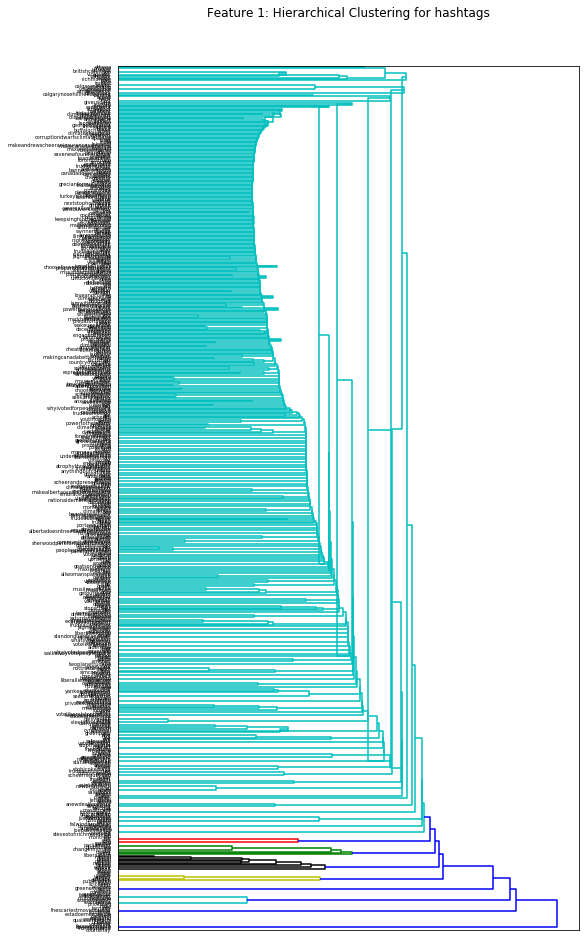

In [0]:
Y = sch.linkage(term_relation_table, method='centroid')
fig = plt.figure(figsize=(16,20))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

ax1.set_title('Feature 1: Hierarchical Clustering for hashtags',y=1.05)
Z1 = sch.dendrogram(Y, orientation='right', labels=vectorizer.get_feature_names())
ax1.set_xticks([])
plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layou
plt.plot() # supress prints

- Figure 1 displays hierarchical clustering for hashtags that were extracted from the 1000 random sample data points. The minimum number of clusters for the hashtags "conservative", "liberal", "ndp" to be grouped into different clusters is 69; however, overlaps of related hashtags in different groups were observed. The hashtags are further clustered into 100 groups and labelled with the four political categories under scrutiny. The clu7sters for these four groups are as follows:
  1. "conservative": 0, 1, 10, 15, 18, 42, 47, 54, 88, 
  2. "liberal": 3, 9, 11, 12, 13, 19, 27, 36, 43, 50, 52, 53, 55, 57, 60, 62, 64, 67, 68, 81, 87, 89, 93, 99
  3. "ndp": 5, 8, 35, 39, 49, 
  4. "none": 2, 4, 6, 7, 14, 16, 17, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 37, 38, 40, 41, 44, 45, 46, 48, 51, 56, 58, 59, 61, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 90, 91, 92, 94, 95, 96, 97, 98 (none covers other political parties like green and people's party and irrelevant topics)
  

In [0]:
cluster = AgglomerativeClustering(n_clusters=100, affinity='euclidean', linkage='ward')
label = cluster.fit_predict(term_relation_table)
term_table = pd.DataFrame(label,index=term_relation_table.index,columns=['label'])
term_table.head()

,label
abc,7
abe,16
ableg,6
abort,4
abpoli,6


In [0]:
term_table[term_table['label']==0]

,label
bekind,0
justvot,0
scheerandpresentdang,0
sexism,0


#### Apply the labels to all the tweets in the 2019 Canadian election dataset. 
- The tweets are attached with political party labels based on its hashtags. Each hashtag is attached with one political party labels. The mode of the hashtags of one tweet ultimately determine the label of the tweet. 

In [0]:
party_dict = {1: [0, 10, 15, 18, 42, 47, 54, 88], #con
2: [3, 9, 11, 12, 13, 19, 27, 36, 43, 50, 52, 53, 55, 57, 60, 62, 64, 67, 68, 81, 87, 89, 93, 99], #liberal
3: [ 5, 8, 35, 39, 49]} #ndp
# 0: [2, 4, 5, 6, 7, 9, 10, 11, 13, 17, 18, 19, 20, 21, 23, 26,
#          27, 28, 29, 30, 31, 32, 34, 35, 37, 42, 92, 45, 47, 49, 50,
#          53, 55, 56, 57, 58, 60, 61, 63, 65, 66, 67, 68, 69, 71, 73,
#          74, 76, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 90, 91, 92,
#          93, 95, 96, 97, 99,]}
key_word_dict = {1: ['admiralnorman', 'andrewcoyn',  'anyonebutsh', 'anythingbutconserv', 'libconsmear', 
                     'liber', 'liberalgovern', 'lyinandi', 'lyingandi', 'makeandrewscheeraninsurancesalesman', 
                     'scheerdesper', 'scheergrift', 'scheerhypocrisi', 'scheerkinsella', 'scheerli', 
                     'scheermajor', 'weakandi'], 2: ['adamformilton', 'chooseforwardwithtrudeau', 'istandwithtrudeau', 
                     'kinsella’，’kinsellag', 'kinsellasnc', 'kinsellout', 'lavscam', 'morneaumustgo', 'teamblackfac',
                     'teamtrudeau', 'trudeamustgo', 'trudeau', 'trudeaublackfac', 'trudeaucorrupt', 'trudeaumania',
                     ' trudeaumustgo', 'trudeausilenc', 'voteliber', 'wynnemustgo'], 3: ['iamwithjagmeet’， ‘ilinnutpiliriavut',
                     'tommulcair', 'votecarol']}


#determine the political party of a given tweet
def get_political(hashtag):
    hashtag = hashtag.split()
    label_list=[]
    for tag in hashtag:
        if tag in term_table.index:
            for i, label in party_dict.items():
                if int(term_table.loc[tag]) in label:
#                     print(i,int(term_table.loc[tag]))
                    label_list.append(i)  
        for i, words in key_word_dict.items():
            if tag in words:
                label_list.append(i)
#     print (label_list)
    if label_list != []:
        label = max(set(label_list), key=label_list.count) #label takes the mode of the list
    else:
        label=0
    
    return label

   

Election_explore = Election_clean.copy()
Election_explore['political party'] = Election_explore['hashtag'].apply(lambda x:get_political(x))
Election_explore.head(10)

,sentiment,negative_reason,text,Tag_User,hashtag,political party
0,0,Women Reproductive right and Racism,rosiebarton instead suggest agre canadian women trust andrewsch conserv govern protect woman right automoni bodi let go cdnpoli elxn43 canada abort,[@RosieBarton],canadian women andrewsch conserv cdnpoli elxn canada abort,1
1,1,NaN,allwomanspacewalk real spacest etobicokenorth cityofto onpoli cdnpoli elxn43,[@Space_Station],allwomanspacewalk etobicokenorth cityofto onpoli cdnpoli elxn,0
2,0,Economy,brantford go cost 94 billion next 4 year ask justin elxn43 cdnpoli canada,[],brantford elxn cdnpoli canada,0
3,1,NaN,canada canadaelection2019 canadavot elxn43 cant decid help,[],canada canadaelect canadavot elxn,1
4,0,Economy,canada taxpay sick tire hard earn donat corpor welfar bum dont need one mani reason trudeaumustgo snclavalin leav canada care sheilacopp snclavalinscand election2019 elxn43 cdnpoli,"[@SNCLavalin, @Sheila_Copps]",canada taxpay trudeaumustgo canada snclavalinscand elect elxn cdnpoli,1
5,0,Others,canadavotes2019 elxn43 cdnpoli fact blastfromthepast 2012 conserv introduc end longgun registri even though head polic across canada victim group object crime control public safeti gunlobbi,[],canadavot elxn cdnpoli blastfromthepast conserv gunlobbi,1
6,1,NaN,cdnmedia elxn43 cdnpoli ppc rocki dong hand best elect video ever pleas googl rocki dong box social havent seen go rocki,[],cdnmedia elxn cdnpoli ppc,0
7,1,NaN,cdnpoli elxn43 liber doubl promis 2015 nation debt next term reelect theyr forecast 90 billion wout nation pharmacar program incl wout ndp coalit 180 billion seem possibl imo,[],cdnpoli elxn,0
8,0,Others,chooseforward cdnpoli elxn43 canada dont make america mistak full frontal tb via youtub,[@YouTube],chooseforward cdnpoli elxn,0
9,0,Scandal,cpckinsellag let see receipt pay warren kinsella make sleaz cdnpoli elxn43 voteliber chooseforward,[],cpckinsellag cdnpoli elxn voteliber chooseforward,2


In [0]:
Election_explore.to_csv("election_explore.csv", sep='\t', encoding='utf-8', index=False)

In [0]:
political = pd.DataFrame(Election_explore['political party'].value_counts())
political

,political party
0,1564
2,274
1,223
3,72


(**Bonus** Graph)

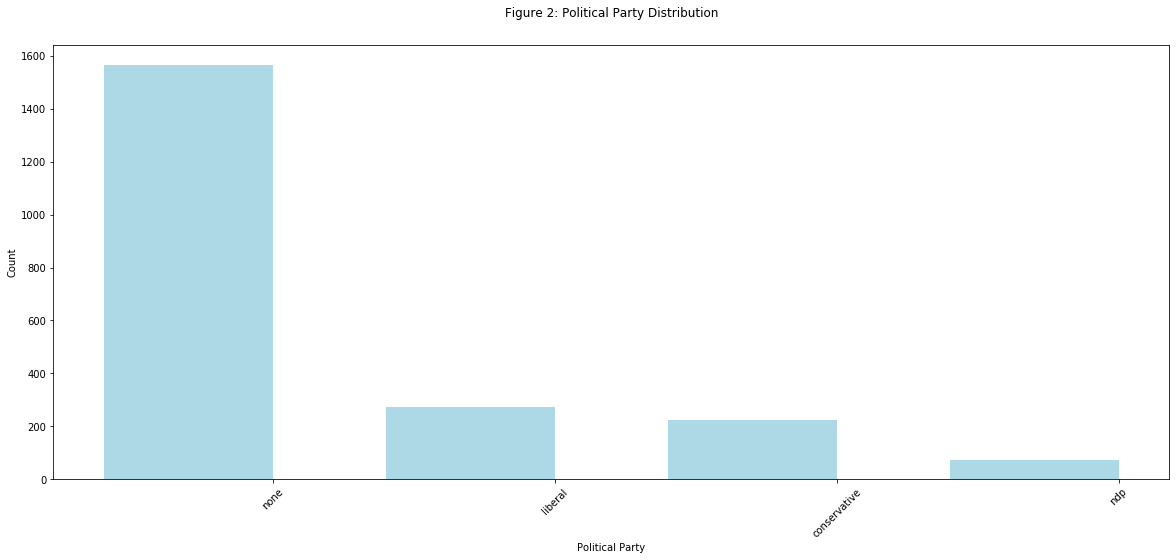

In [0]:
fig, ax = plt.subplots(figsize=(20,8))
ind = np.arange(4)
width = 0.60
political_party_list = ['none','liberal','conservative','ndp']

p = ax.bar(ind,political['political party'].tolist(),width,color='lightblue')

ax.set_title('Feature 2: Salary Distribution by Gender',y=1.05)
ax.set_ylabel('Count')
ax.set_xlabel('Political Party')
ax.set_xticks(ind + width / 2)    
ax.set_xticklabels(political_party_list)
ax.set_title("Figure 2: Political Party Distribution")

plt.xticks(rotation=45)
plt.show()

#### What can we say about the distribution of the political affliations of the tweets?
- Figure 2 shows the political affiliations of all the tweets in the 2019 Canadian elections dataset. Approximately 1500 tweets are labelled with "none". Approximately 200 tweets revolve around the topic of "conservative" party whereas 70 tweets revolve around "ndp" and 274 tweet revolves around "liberal".

#### Sentiment Distribution by Political Party

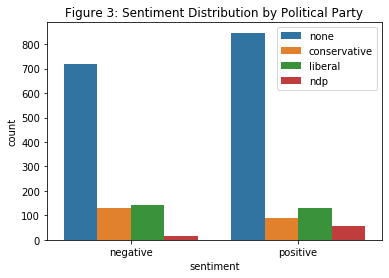

In [0]:
fig, ax =plt.subplots()
g = sns.countplot(x='sentiment', hue='political party', data=Election_explore).set_title('Figure 3: Sentiment Distribution by Political Party')
ax.set_xticklabels(['negative','positive'])
ax.legend(['none','conservative','liberal','ndp'])

- Figure 3 shows the sentiment distribution by political party. There are more negative tweets regarding the conservative party than postive where as the liberal party has slightly more negative tweets. The number of positive tweets regarding ndp outnumbers the negative tweets.

### Plot word cloud for 100 most frequently used words
#### Find top 100 the most frequently used words from Canadian Election tweets.

In [0]:
Canadian_election_dict = nltk.FreqDist(Election_clean['text'])
Canadian_election_common_words = Canadian_election_dict.most_common(100)

#### Find top 100 the most frequently used words from Generic Tweets.

In [0]:
Tweet_dict = nltk.FreqDist(Tweet_clean['text'])
Tweet_common_words = Tweet_dict.most_common(100)

#### Build word cloud for Canadian Election tweet common words¶

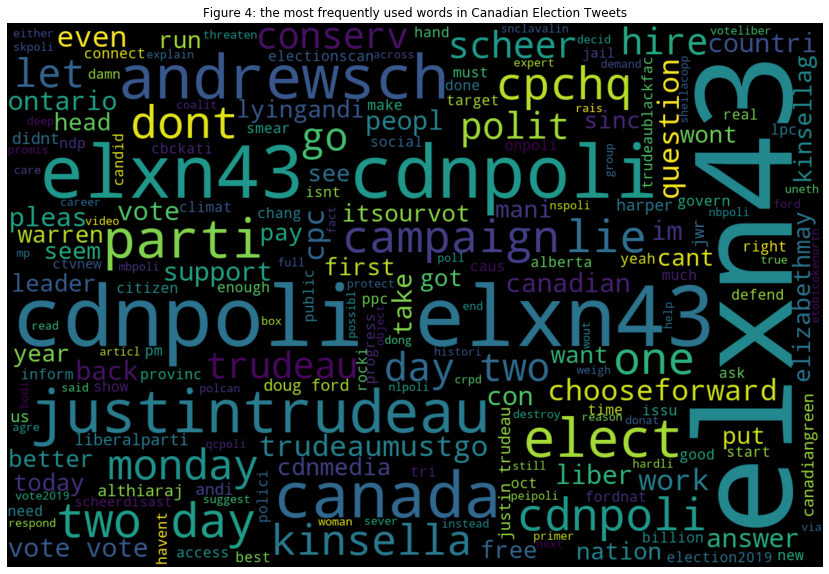

In [0]:
string = ' '.join(w[0] for w in Canadian_election_common_words)
Canadian_election_wordcloud = WordCloud(width = 1200, height = 800).generate(string)

plt.figure(figsize=(20,10))
plt.imshow(Canadian_election_wordcloud, interpolation='bilinear')
plt.title('Figure 4: the most frequently used words in Canadian Election Tweets')
plt.axis("off")
plt.show()

#### Build word cloud for Generic tweet common words

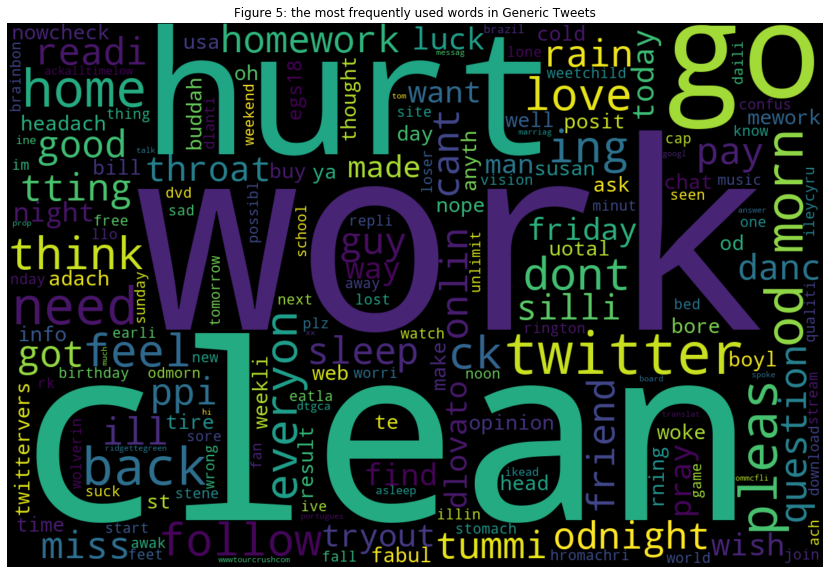

In [0]:
string = ' '.join(w[0] for w in Tweet_common_words)
Tweet_wordcloud = WordCloud(width = 1200, height = 800).generate(string)

plt.figure(figsize=(20,10))
plt.imshow(Tweet_wordcloud, interpolation='bilinear')
plt.title('Figure 5: the most frequently used words in Generic Tweets')
plt.axis("off")
plt.show()

## Step 3 - Model Preparation
### Two Types of Features
#### Word Frequency (Bag of words)
Because my laptop configuration does not allow me to process the entire dataset (crashed on colab when I tried to vectorize the whole dataset/kernel died on Jupiter Notebook), I boostrapped 6000 data points to train the models to ensure the representativeness of the sample and estimate statistics on all tweets.

In [0]:
#boostrap
n_samples = 6000
Tweet_sample = Tweet_clean.sample(n=n_samples, random_state=1, replace=True)
Tweet_sample = Tweet_sample.reset_index(drop=True)

In [0]:
vectorizer_WF = CountVectorizer(max_features=1000)
array_T_WF = vectorizer_WF.fit_transform(Tweet_sample['text']).toarray()

#### Term Frequency–Inverse Document Frequency (TF-IDF)

In [0]:
vectorizer_TFIDF = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=1000)
array_TFIDF = vectorizer_TFIDF.fit_transform(Tweet_sample['text']).toarray()

### Splitting the dataset into training/testing sets

In [0]:
X_WF = array_T_WF
X_TFIDF = array_TFIDF
y = Tweet_sample['class']

X_WF_train, X_WF_test, y_WF_train, y_WF_test = train_test_split(X_WF,y,test_size=0.3)
X_TFIDF_train, X_TFIDF_test, y_TFIDF_train, y_TFIDF_test = train_test_split(X_TFIDF,y,test_size=0.3)

## Step 4 Model Implementation
### Train the Models
#### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

model1_WF = LogisticRegression()
model1_TFIDF = LogisticRegression()

model1_WF.fit(X_WF_train,y_WF_train)
model1_TFIDF.fit(X_TFIDF_train,y_TFIDF_train)

y1_WF_pred = model1_WF.predict(X_WF_test)
y1_TFIDF_pred = model1_TFIDF.predict(X_TFIDF_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print(confusion_matrix(y_WF_test, y1_WF_pred))
print(classification_report(y_WF_test, y1_WF_pred,digits=5))

[[620 249]
 [245 686]]
              precision    recall  f1-score   support

           0    0.71676   0.71346   0.71511       869
           1    0.73369   0.73684   0.73526       931

    accuracy                        0.72556      1800
   macro avg    0.72523   0.72515   0.72519      1800
weighted avg    0.72552   0.72556   0.72553      1800



In [0]:
print(confusion_matrix(y_TFIDF_test, y1_TFIDF_pred))
print(classification_report(y_TFIDF_test, y1_TFIDF_pred,digits=5))

[[595 296]
 [244 665]]
              precision    recall  f1-score   support

           0    0.70918   0.66779   0.68786       891
           1    0.69199   0.73157   0.71123       909

    accuracy                        0.70000      1800
   macro avg    0.70058   0.69968   0.69955      1800
weighted avg    0.70050   0.70000   0.69966      1800



##### K-NN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

model2_WF = KNeighborsClassifier(n_neighbors=5)
model2_TFIDF = KNeighborsClassifier(n_neighbors=5)

model2_WF.fit(X_WF_train,y_WF_train)
model2_TFIDF.fit(X_TFIDF_train,y_TFIDF_train)

y2_WF_pred = model2_WF.predict(X_WF_test)
y2_TFIDF_pred = model2_TFIDF.predict(X_TFIDF_test)

In [0]:
print(confusion_matrix(y_WF_test, y2_WF_pred))
print(classification_report(y_WF_test, y2_WF_pred,digits=5))

[[456 413]
 [282 649]]
              precision    recall  f1-score   support

           0    0.61789   0.52474   0.56752       869
           1    0.61111   0.69710   0.65128       931

    accuracy                        0.61389      1800
   macro avg    0.61450   0.61092   0.60940      1800
weighted avg    0.61438   0.61389   0.61084      1800



In [0]:
print(confusion_matrix(y_TFIDF_test, y2_TFIDF_pred))
print(classification_report(y_TFIDF_test, y2_TFIDF_pred,digits=5))

[[494 397]
 [320 589]]
              precision    recall  f1-score   support

           0    0.60688   0.55443   0.57947       891
           1    0.59736   0.64796   0.62164       909

    accuracy                        0.60167      1800
   macro avg    0.60212   0.60120   0.60055      1800
weighted avg    0.60207   0.60167   0.60076      1800



#### SVM

In [0]:
import sklearn.svm as sksvm

model3_WF = sksvm.SVC(kernel='rbf', gamma ='auto')
model3_TFIDF = sksvm.SVC(kernel='rbf', gamma ='auto')

model3_WF.fit(X_WF_train, y_WF_train)
model3_TFIDF.fit(X_TFIDF_train, y_TFIDF_train)

y3_WF_pred = model3_WF.predict(X_WF_test)
y3_TFIDF_pred = model3_TFIDF.predict(X_TFIDF_test)

In [0]:
print(confusion_matrix(y_WF_test, y3_WF_pred))
print(classification_report(y_WF_test, y3_WF_pred,digits=5))

[[789  80]
 [673 258]]
              precision    recall  f1-score   support

           0    0.53967   0.90794   0.67696       869
           1    0.76331   0.27712   0.40662       931

    accuracy                        0.58167      1800
   macro avg    0.65149   0.59253   0.54179      1800
weighted avg    0.65534   0.58167   0.53714      1800



In [0]:
print(confusion_matrix(y_TFIDF_test, y3_TFIDF_pred))
print(classification_report(y_TFIDF_test, y3_TFIDF_pred,digits=5))

[[571 320]
 [200 709]]
              precision    recall  f1-score   support

           0    0.74060   0.64085   0.68712       891
           1    0.68902   0.77998   0.73168       909

    accuracy                        0.71111      1800
   macro avg    0.71481   0.71042   0.70940      1800
weighted avg    0.71455   0.71111   0.70963      1800



#### Decision Trees

In [0]:
from sklearn.tree import DecisionTreeClassifier

model4_WF = DecisionTreeClassifier(criterion='entropy')
model4_TFIDF = DecisionTreeClassifier(criterion='entropy')

model4_WF.fit(X_WF_train, y_WF_train)
model4_TFIDF.fit(X_TFIDF_train, y_TFIDF_train)

y4_WF_pred = model4_WF.predict(X_WF_test)
y4_TFIDF_pred = model4_TFIDF.predict(X_TFIDF_test)

In [0]:
print(confusion_matrix(y_WF_test, y4_WF_pred))
print(classification_report(y_WF_test, y4_WF_pred,digits=5))

[[590 279]
 [327 604]]
              precision    recall  f1-score   support

           0    0.64340   0.67894   0.66069       869
           1    0.68403   0.64876   0.66593       931

    accuracy                        0.66333      1800
   macro avg    0.66372   0.66385   0.66331      1800
weighted avg    0.66442   0.66333   0.66340      1800



In [0]:


print(confusion_matrix(y_TFIDF_test, y4_TFIDF_pred))
print(classification_report(y_TFIDF_test, y4_TFIDF_pred,digits=5))

[[547 344]
 [300 609]]
              precision    recall  f1-score   support

           0    0.64581   0.61392   0.62946       891
           1    0.63903   0.66997   0.65414       909

    accuracy                        0.64222      1800
   macro avg    0.64242   0.64194   0.64180      1800
weighted avg    0.64239   0.64222   0.64192      1800



#### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

model5_WF = RandomForestClassifier(n_estimators=100)
model5_TFIDF = RandomForestClassifier(n_estimators=100)

model5_WF.fit(X_WF_train, y_WF_train)
model5_TFIDF.fit(X_TFIDF_train, y_TFIDF_train)

y5_WF_pred = model5_WF.predict(X_WF_test)
y5_TFIDF_pred = model5_TFIDF.predict(X_TFIDF_test)

In [0]:
print(confusion_matrix(y_WF_test, y5_WF_pred))
print(classification_report(y_WF_test, y5_WF_pred,digits=5))

[[654 215]
 [279 652]]
              precision    recall  f1-score   support

           0    0.70096   0.75259   0.72586       869
           1    0.75202   0.70032   0.72525       931

    accuracy                        0.72556      1800
   macro avg    0.72649   0.72646   0.72556      1800
weighted avg    0.72737   0.72556   0.72554      1800



In [0]:
print(confusion_matrix(y_TFIDF_test, y5_TFIDF_pred))
print(classification_report(y_TFIDF_test, y5_TFIDF_pred,digits=5))

[[636 255]
 [258 651]]
              precision    recall  f1-score   support

           0    0.71141   0.71380   0.71261       891
           1    0.71854   0.71617   0.71736       909

    accuracy                        0.71500      1800
   macro avg    0.71498   0.71499   0.71498      1800
weighted avg    0.71501   0.71500   0.71500      1800



#### Xgboost

In [0]:
import xgboost as xgb
WF_train = xgb.DMatrix(X_WF_train, label=y_WF_train)
WF_test = xgb.DMatrix(X_WF_test, label = y_WF_test)
TFIDF_train =  xgb.DMatrix(X_TFIDF_train, label=y_TFIDF_train)
TFIDF_test = xgb.DMatrix(X_TFIDF_test, label=y_TFIDF_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 
steps = 20

model6_WF = xgb.train(param, WF_train, steps)
model6_TFIDF = xgb.train(param, TFIDF_train, steps)

y6_WF_pred = model6_WF.predict(WF_test)
y6_TFIDF_pred = model6_TFIDF.predict(TFIDF_test)

best_preds_WF = np.asarray([np.argmax(line) for line in y6_WF_pred])
best_preds_TFIDF = np.asarray([np.argmax(line) for line in y6_TFIDF_pred])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
print(confusion_matrix(y_WF_test, best_preds_WF))
print(classification_report(y_WF_test, best_preds_WF,digits=5))

[[502 367]
 [216 715]]
              precision    recall  f1-score   support

           0    0.69916   0.57768   0.63264       869
           1    0.66081   0.76799   0.71038       931

    accuracy                        0.67611      1800
   macro avg    0.67999   0.67283   0.67151      1800
weighted avg    0.67933   0.67611   0.67285      1800



In [0]:
print(confusion_matrix(y_TFIDF_test, best_preds_TFIDF))
print(classification_report(y_TFIDF_test, best_preds_TFIDF,digits=5))

[[475 416]
 [182 727]]
              precision    recall  f1-score   support

           0    0.72298   0.53311   0.61370       891
           1    0.63605   0.79978   0.70858       909

    accuracy                        0.66778      1800
   macro avg    0.67951   0.66644   0.66114      1800
weighted avg    0.67908   0.66778   0.66161      1800



#### 　Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

model7_WF = GaussianNB()
model7_TFIDF = GaussianNB()

model7_WF.fit(X_WF_train, y_WF_train)
model7_TFIDF.fit(X_TFIDF_train, y_TFIDF_train)

y7_WF_pred = model7_WF.predict(X_WF_test)
y7_TFIDF_pred = model7_TFIDF.predict(X_TFIDF_test)

In [0]:
print(confusion_matrix(y_WF_test, y7_WF_pred))
print(classification_report(y_WF_test, y7_WF_pred,digits=5))

[[416 453]
 [175 756]]
              precision    recall  f1-score   support

           0    0.70389   0.47871   0.56986       869
           1    0.62531   0.81203   0.70654       931

    accuracy                        0.65111      1800
   macro avg    0.66460   0.64537   0.63820      1800
weighted avg    0.66325   0.65111   0.64056      1800



In [0]:
print(confusion_matrix(y_TFIDF_test, y7_TFIDF_pred))
print(classification_report(y_TFIDF_test, y7_TFIDF_pred,digits=5))

[[456 435]
 [179 730]]
              precision    recall  f1-score   support

           0    0.71811   0.51178   0.59764       891
           1    0.62661   0.80308   0.70395       909

    accuracy                        0.65889      1800
   macro avg    0.67236   0.65743   0.65080      1800
weighted avg    0.67190   0.65889   0.65133      1800



### Accuracy Score Distribution for Algorithms by Types of Data Transformation

In [0]:
from sklearn.metrics import accuracy_score

WF = pd.Series([accuracy_score(y_WF_test, y1_WF_pred), accuracy_score(y_WF_test, y2_WF_pred), accuracy_score(y_WF_test, y3_WF_pred),
               accuracy_score(y_WF_test, y4_WF_pred), accuracy_score(y_WF_test, y5_WF_pred), accuracy_score(y_WF_test, best_preds_WF),
               accuracy_score(y_WF_test, y7_WF_pred)])
TFIDF = pd.Series([accuracy_score(y_TFIDF_test, y1_TFIDF_pred), accuracy_score(y_TFIDF_test, y2_TFIDF_pred), accuracy_score(y_TFIDF_test, y3_TFIDF_pred),
               accuracy_score(y_TFIDF_test, y4_TFIDF_pred), accuracy_score(y_TFIDF_test, y5_TFIDF_pred), accuracy_score(y_TFIDF_test, best_preds_TFIDF),
               accuracy_score(y_WF_test, y7_WF_pred)])
a = pd.concat([WF, TFIDF], axis=1)
a.columns = ['WF','TFIDF']

In [0]:
a

,WF,TFIDF
0,0.725556,0.700000
1,0.613889,0.601667
2,0.581667,0.711111
3,0.663333,0.642222
4,0.725556,0.715000
5,0.676111,0.667778
6,0.651111,0.651111


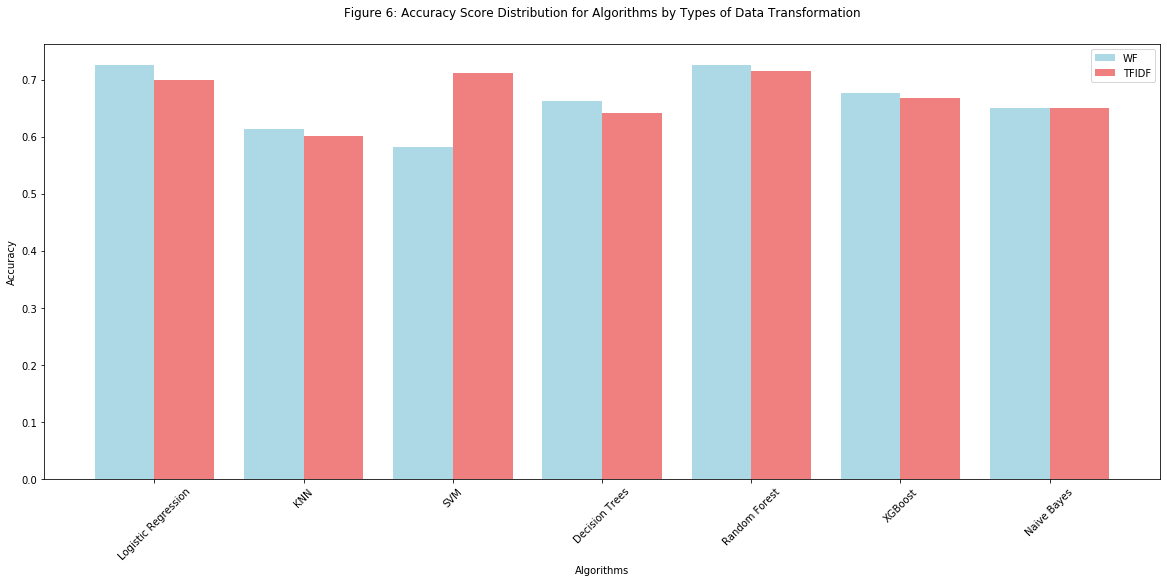

In [0]:
Algorithm_list = ['Logistic Regression', 'KNN', 'SVM', 'Decision Trees', 'Random Forest',
                  'XGBoost', 'Naive Bayes']

fig, ax = plt.subplots(figsize=(20,8))
ind = np.arange(len(Algorithm_list))
width = 0.40

WF = a['WF'].tolist()
TFIDF = a['TFIDF'].tolist()

p1 = ax.bar(ind,WF,width,color='lightblue')
p2 = ax.bar(ind+width,TFIDF,width,color='lightcoral')

ax.set_title('Figure 6: Accuracy Score Distribution for Algorithms by Types of Data Transformation',y=1.05)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Algorithms')
ax.set_xticks(ind + width / 2)    
ax.set_xticklabels(Algorithm_list)

ax.legend((p1[0], p2[0]), ('WF', 'TFIDF'))

plt.xticks(rotation=45)
plt.show()

- Figure 6 shows accuracy score distribution for algorithms by types of data transformation. Logistic regression with WF and random forest performed the best among all the algorithms, reaching an accuracy of 72.56%. The same model will be evaluated on the 2019 Canadian elections data. 

### Model Evaluation on Canadian Election Dataset
Both logistic regression and random forest achieved 72.56 percent of accuracy. Because logistic regression's false positive number and false negative number are more balanced (249, 245) than random forest (215, 279), the logistic regression model is implemented with overlap columns between the generic dataset and the Election dataset after count vectorization.
#### Word Frequency

In [0]:
vectorizer_E = CountVectorizer(max_features=1000)
array_E = vectorizer_E.fit_transform(Election_explore['text']).toarray()
# vectorizer_WF = CountVectorizer(max_features=1000)
# array_T_WF = vectorizer_WF.fit_transform(Tweet_sample['text']).toarray()

# X_WF = array_T_WF
# y = Tweet_sample['class']

# X_WF_train, X_WF_test, y_WF_train, y_WF_test = train_test_split(X_WF,y,test_size=0.3)

In [0]:
E_table = pd.DataFrame(array_E, columns=vectorizer_E.get_feature_names())
Generic_table = pd.DataFrame(array_T_WF, columns=vectorizer_WF.get_feature_names())
## Find the overlap columns
overlap_columns = list(set(E_table.columns).intersection(set(Generic_table.columns)))

In [0]:
#fit the model with the overlap columns and predict
new_gen_table = Generic_table[overlap_columns]
new_e_table = E_table[overlap_columns]
model1_WF_new = LogisticRegression()
model1_WF_new.fit(new_gen_table, y)
y__E_pred = model1_WF_new.predict(new_e_table)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [318]:
print(confusion_matrix(Election_explore['sentiment'], y__E_pred))
print(classification_report(Election_explore['sentiment'], y__E_pred,digits=5))

[[507 499]
 [525 602]]
              precision    recall  f1-score   support

           0    0.49128   0.50398   0.49755      1006
           1    0.54678   0.53416   0.54039      1127

    accuracy                        0.51992      2133
   macro avg    0.51903   0.51907   0.51897      2133
weighted avg    0.52060   0.51992   0.52019      2133



#### Sentiment Prediction Results Visualization

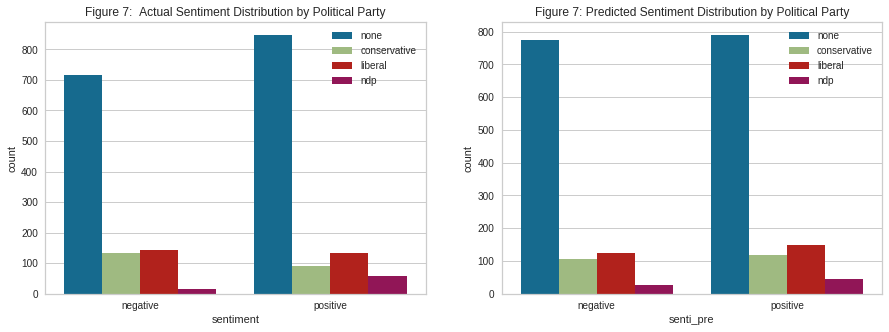

In [320]:
Election_explore['senti_pre'] = y__E_pred
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sns.countplot(x='sentiment', hue='political party', 
                  data=Election_explore, ax=ax1).set_title('Figure 7:  Actual Sentiment Distribution by Political Party')
ax1.set_xticklabels(['negative','positive'])
ax1.legend(['none','conservative','liberal','ndp'])


sns.countplot(x='senti_pre', hue='political party', data=Election_explore, ax=ax2).set_title('Figure 7: Predicted Sentiment Distribution by Political Party')
ax2.set_xticklabels(['negative','positive'])#)
ax2.legend(['none','conservative','liberal','ndp'])


- Figure 7 shows the Canadian Election tweets sentiment prediction results and the true sentiment for each of the 3 parties. Positive comments on ndp still slightly outnumbers negative comments; however, as opposed to the true sentiment, positive comments on the conservative party and the liberal party outnumbers negative comments.

In [0]:
Election_explore['sentiment'].value_counts()

1    1127
0    1006
Name: sentiment, dtype: int64

In [0]:
Election_explore['senti_pre'].value_counts()

1    1101
0    1032
Name: senti_pre, dtype: int64

### Negative Tweets Reason Prediction

In [0]:
Election_explore.head(3)

,sentiment,negative_reason,text,Tag_User,hashtag,political party
0,0,Women Reproductive right and Racism,rosiebarton instead suggest agre canadian women trust andrewsch conserv govern protect woman right automoni bodi let go cdnpoli elxn43 canada abort,[@RosieBarton],canadian women andrewsch conserv cdnpoli elxn canada abort,1
1,1,NaN,allwomanspacewalk real spacest etobicokenorth cityofto onpoli cdnpoli elxn43,[@Space_Station],allwomanspacewalk etobicokenorth cityofto onpoli cdnpoli elxn,0
2,0,Economy,brantford go cost 94 billion next 4 year ask justin elxn43 cdnpoli canada,[],brantford elxn cdnpoli canada,0


In [0]:
Election_explore['negative_reason'].unique()

array(['Women Reproductive right and Racism', nan, 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

#### Combine Similar Reasons into 8 Categories
The negative reasons behind the value of the labels are as follows:
0. Others and nan
1. Women Reproductive right and Racism
2. Economy
3. Scandal and Tell lies
4. Privilege  
5. Climate Problem
6. Separation 
7. Healthcare and Healthcare and Marijuana

I grouped "Scandal" and "Tell lies" together because when politicians are caught telling lies, that could be seen as a scandal. These two categories are both negative perspectives of either a party or a politician. "Healthcare" and "Healthcare and Marijuana" are closely related to each other, and thus grouped together.


In [0]:
def get_negative_reason(tweet):
    if tweet == 'Women Reproductive right and Racism':
        tweet = 1
    elif tweet == 'Economy':
        tweet = 2
    elif tweet == "Scandal" or tweet == "Tell lies":
        tweet = 3
    elif tweet == 'Privilege':
        tweet = 4
    elif tweet == 'Climate Problem':
        tweet = 5
    elif tweet == 'Separation':
        tweet = 6
    elif tweet == 'Healthcare' or tweet == 'Healthcare and Marijuana':
        tweet = 7
    else:
        tweet =0
    
    return tweet

Election_explore1 = Election_explore.copy()
Election_explore1['negative_reason'] = Election_explore1['negative_reason'].apply(get_negative_reason)

In [0]:
reason_dist = Election_explore1['negative_reason'].value_counts()

#### Split the Data

In [0]:
X_E = array_E
y_E = Election_explore1['negative_reason']
X_E_train, X_E_test, y_E_train, y_E_test = train_test_split(X_E, y_E,test_size=0.3)

#### Train the Model
I chose three algorithms with the best performance on the generic dataset with the WF columns: **Logistic Regression, Random Forest, and XGBoost**. I then trained the models with WF of the Canadian Election dataset.  
##### Logistic Regression

In [0]:
model1_E = LogisticRegression()
model1_E.fit(X_E_train,y_E_train)
y1_E_pred = model1_WF.predict(X_E_test)
print(confusion_matrix(y_E_test, y1_E_pred))
print(classification_report(y_E_test, y1_E_pred,digits=5))

[[370  85   0   0   0   0   0   0]
 [ 14   3   0   0   0   0   0   0]
 [ 12   1   0   0   0   0   0   0]
 [104  26   0   0   0   0   0   0]
 [  2   3   0   0   0   0   0   0]
 [ 10   3   0   0   0   0   0   0]
 [  2   1   0   0   0   0   0   0]
 [  4   0   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0    0.71429   0.81319   0.76053       455
           1    0.02459   0.17647   0.04317        17
           2    0.00000   0.00000   0.00000        13
           3    0.00000   0.00000   0.00000       130
           4    0.00000   0.00000   0.00000         5
           5    0.00000   0.00000   0.00000        13
           6    0.00000   0.00000   0.00000         3
           7    0.00000   0.00000   0.00000         4

    accuracy                        0.58281       640
   macro avg    0.09236   0.12371   0.10046       640
weighted avg    0.50847   0.58281   0.54184       640



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### Random Forest

In [0]:
model2_E = RandomForestClassifier(n_estimators=100)
model2_E.fit(X_E_train, y_E_train)
y2_E_pred = model2_E.predict(X_E_test)
print(confusion_matrix(y_E_test, y2_E_pred))
print(classification_report(y_E_test, y2_E_pred,digits=5))

[[430   1   0  24   0   0   0   0]
 [  8   5   0   4   0   0   0   0]
 [ 11   0   1   1   0   0   0   0]
 [ 67   1   0  62   0   0   0   0]
 [  5   0   0   0   0   0   0   0]
 [ 12   0   0   1   0   0   0   0]
 [  2   0   0   1   0   0   0   0]
 [  3   0   0   1   0   0   0   0]]
              precision    recall  f1-score   support

           0    0.79926   0.94505   0.86606       455
           1    0.71429   0.29412   0.41667        17
           2    1.00000   0.07692   0.14286        13
           3    0.65957   0.47692   0.55357       130
           4    0.00000   0.00000   0.00000         5
           5    0.00000   0.00000   0.00000        13
           6    0.00000   0.00000   0.00000         3
           7    0.00000   0.00000   0.00000         4

    accuracy                        0.77812       640
   macro avg    0.39664   0.22413   0.24739       640
weighted avg    0.74148   0.77812   0.74213       640



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### XGBoost

In [0]:
D_train = xgb.DMatrix(X_E_train, label=y_E_train)
D_test = xgb.DMatrix(X_E_test, label = y_E_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 8} 
steps = 20

model3_E = xgb.train(param, D_train, steps)
y3_E_pred = model3_E.predict(D_test)
best_preds_E = np.asarray([np.argmax(line) for line in y3_E_pred])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
print(confusion_matrix(y_E_test, best_preds_E))
print(classification_report(y_E_test, best_preds_E,digits=5))

[[437   3   0  13   0   2   0   0]
 [  6  10   0   1   0   0   0   0]
 [ 12   0   1   0   0   0   0   0]
 [ 79   4   0  47   0   0   0   0]
 [  4   0   0   1   0   0   0   0]
 [ 12   0   0   0   0   1   0   0]
 [  2   0   0   1   0   0   0   0]
 [  4   0   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0    0.78597   0.96044   0.86449       455
           1    0.58824   0.58824   0.58824        17
           2    1.00000   0.07692   0.14286        13
           3    0.74603   0.36154   0.48705       130
           4    0.00000   0.00000   0.00000         5
           5    0.33333   0.07692   0.12500        13
           6    0.00000   0.00000   0.00000         3
           7    0.00000   0.00000   0.00000         4

    accuracy                        0.77500       640
   macro avg    0.43170   0.25801   0.27595       640
weighted avg    0.75302   0.77500   0.73460       640



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Step 5 - Results
## First Model
### Interpretation of the Results

As figure 2&3 shows, although the Conservative party and the Liberal party engage people in heated discussions, they seem to receive more abuse than praise. The New Democratic Party engages fewer people in discussions but they are more reputable.
Figure 7 shows the Canadian Election tweets sentiment prediction results and the true sentiment for each of the 3 parties. Positive comments on ndp still slightly outnumbers negative comments; however, as opposed to the true sentiment, positive comments on the conservative party and the liberal party outnumbers negative comments. 

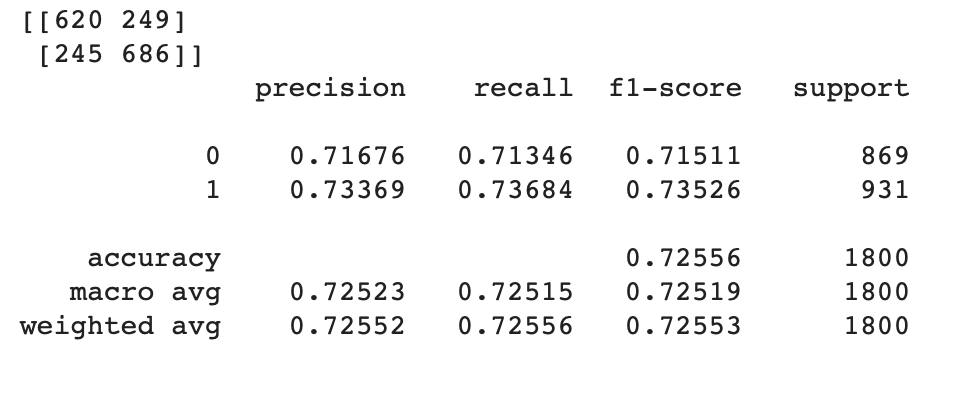
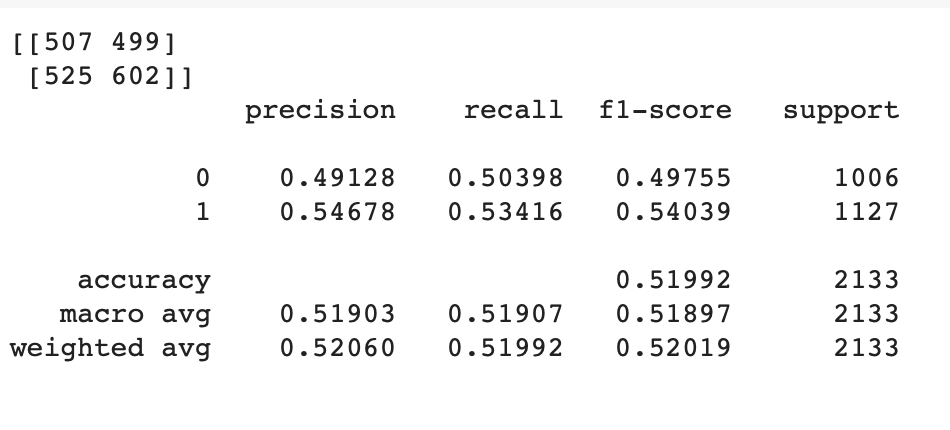


We notice there is a difference bettween the actual label and the predicted label in people's general opinion on the parties. The confusion matrix and classification of the logistic regression model indicates an decline in accuracy. This may be due to the fact that features that do not overlap between the Canadian Election dataset and the generic dataset are dropped. Initially the features were set to 1000. After filtering out the distinct features, there was 277 features left. If more features were added to the model, the accuracy could be improved. The decline in accuracy could also be due to overfitting of the first model to the generic dataset. Further hyperparameter tunning can help improve the performance of the model. 

### Usefulness of Sentiment Analysis
This result tells us NLP analytics based on tweets is useful for political parties during election campaigns. With better implementation of the model, the accuracy of predicting twitter users' dispostion in favour of or against a party can be improved. With NLP techniques, we can have a general understanding of its distribution in an effort to better predict the election result. However, we should also be aware that the process of building, training, and implementing the model involves considerable subjective decision making and human reasoning, for example, how to clean the data, how to process the data (WF? TFIDF? which may lead to drastic difference in accuracy), what model to choose, how many features to select, etc; thus this process can be biased. The result of NLP result should not be treated as an ultimate truth.

## Second Model

Overall, the second model did poorly on predicting label 2, 4, 5, 6, 7. The three models (logistic regression, random forest, XGBoost) reached an accuracy of 58.28%, 77.81%, and 77.51% respectively. The acceptable accuracy score results from the majority of the data points are predicted with label 0 ("Other" or nan). Random forest has the best performance but still fails to predict label 4 to 7. It performs better at predicting label 1 and 3. Figure 8 shows the distribution of negative reason labels. After data processing where labels were combined based on its relevance. Label 0 and 3 significantly outnumbers other labels. One approach to improve the performance of the model is to combine the labels that have few data points together to have the labels more equally distributed, but this can lead to difficulty in interpreting the results because the combination of the labels may not be able to be justified. Hyperparameter tunning can also be adopted to improve the accuracy.

<BarContainer object of 8 artists>

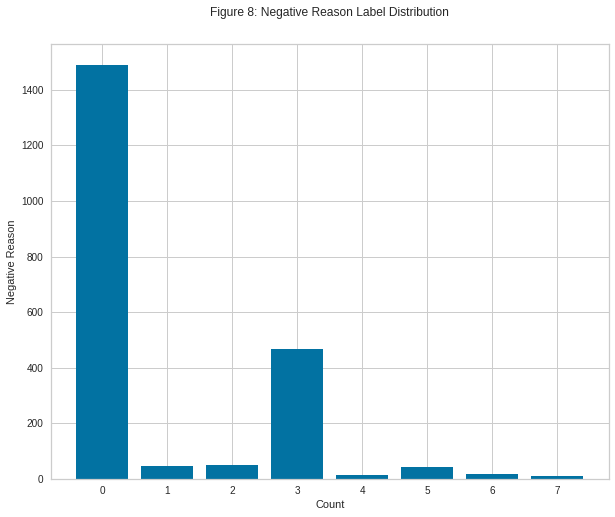

In [333]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Figure 8: Negative Reason Label Distribution',y=1.05)
ax.set_ylabel('Negative Reason')
ax.set_xlabel('Count')
centers = [0, 1, 2,3,4,5,6,7]
width = 0.8
reason_dist = [1491, 45, 51, 468, 12, 41, 16, 9]
plt.bar(centers, reason_dist, width=width)

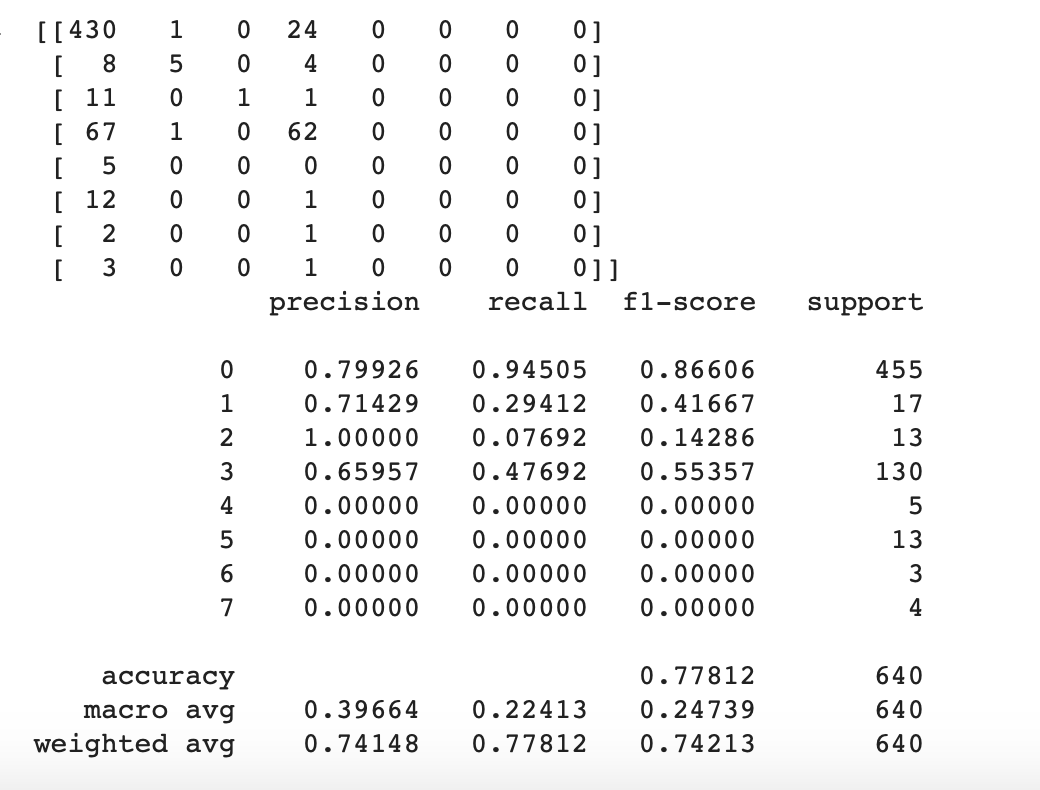